## 1. 오토인코더
오토인코더(Autoencoder)는 입력 데이터를 효율적으로 압축하고 다시 복원하는 것을 목표로 하는 인공신경망 기반의 비지도 학습 모델입니다. 인코더(encoder)라는 신경망 구조를 통해 입력 데이터를 저차원(latent space)의 잠재 표현으로 변환하고, 디코더(decoder)를 통해 이를 다시 원래의 입력 데이터로 복원합니다. 학습은 원본 입력과 복원된 출력 간의 재구성 오류(reconstruction error)를 최소화하는 방식으로 이루어지며, 이를 통해 데이터의 핵심 특징을 추출하거나 노이즈 제거, 차원 축소 등에 활용됩니다. 오토인코더는 생성 모델의 기초가 되는 구조로서, 이후 변분 오토인코더(VAE)나 GAN과 같은 발전된 모델에도 큰 영향을 주었습니다.

** GAN : 실제로 존재하지 않은 이미지를 생성할 때 사용됨

<img src="https://blog.kakaocdn.net/dna/bKtH0x/btsPVyfFPUG/AAAAAAAAAAAAAAAAAAAAAA4ziXc3taZfTseUUQ0lYcRBjom6vvio_c1KYycTDSZr/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1756652399&allow_ip=&allow_referer=&signature=3kRY52VHQ%2Fu2En0hQ6fjjieensQ%3D">

### 1. 인코더 (Encoder): 데이터를 요약하는 압축기
인코더는 고차원 데이터를 받아서, 그 핵심적인 특징만을 담은 저차원 잠재 표현(latent vector)으로 바꿔줍니다.

- 입력 이미지가 28x28 픽셀이라면, 총 784개의 숫자가 들어옵니다.
- 인코더는 이 784개의 숫자 중에서 정말 중요한 특징만 뽑아내서, 예를 들어 32차원 벡터로 요약합니다. 이걸 보통 잠재 공간(latent space)이라고 부릅니다.

### 2. 디코더 (Decoder): 요약 정보를 복원하는 재생기
디코더는 인코더가 만든 요약 정보를 보고, 최대한 원래 데이터와 비슷하게 복원하려고 합니다.

- 인코더가 만든 32차원의 벡터를 받아서,
- 다시 784개의 숫자 (28x28 이미지)로 복원하려고 합니다.
- 이 때, 인코더에서 잃은 정보를 복원하기 때문에, 완전히 같진 않을 수 있지만 비슷하게 재현하려고 합니다.

## 2. 오토인코더 구현하기

In [2]:
!pip install tensorflow

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

In [6]:
# MNIST 데이터셋을 불러옵니다.

(X_train, _), (X_test, _) = mnist.load_data()

In [8]:
X_test.shape

(10000, 28, 28)

In [9]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255  # (60000, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255     # (10000, 28, 28)

In [10]:
# 생성자 모델을 만듭니다.
autoencoder = Sequential()

In [11]:
# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))  # (14, 14, 16)
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))    # (14, 14, 8)
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))  # (7, 7, 8)
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu')) # (4, 4, 8)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# 디코딩 부분입니다.
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu')) # (4, 4, 8)
autoencoder.add(UpSampling2D()) # (8, 8, 8)
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))    # (8, 8, 8)
autoencoder.add(UpSampling2D()) # (16, 16, 8)
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))   # (14, 14, 16)
autoencoder.add(UpSampling2D()) # (28, 28, 16)
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')) # (28, 28. 1)

In [13]:
# 전체 구조를 확인합니다.
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 75s 152ms/step - loss: 0.3083 - val_loss: 0.1334
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 145ms/step - loss: 0.1288 - val_loss: 0.1167
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 153ms/step - loss: 0.1162 - val_loss: 0.1104
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 146ms/step - loss: 0.1096 - val_loss: 0.1058
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 149ms/step - loss: 0.1061 - val_loss: 0.1027
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 146ms/step - loss: 0.1035 - val_loss: 0.1009
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 150ms/step - loss: 0.1018 - val_loss: 0.0990
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 157ms/step - loss: 0.1001 - val_loss: 0.0976
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 148ms/step - loss: 0.0987 - val_loss: 0.0967
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 155ms/step - loss: 0.0973 - val_loss: 0.0950
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 149ms/step - loss: 0.0962 - val_loss: 0.0948
Epoch 12/50
469/469

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


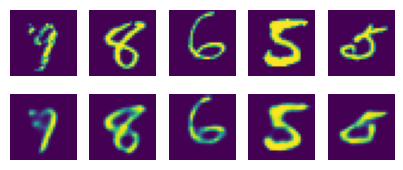

In [15]:
# 학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = autoencoder.predict(X_test)                     # 앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(7, 2))                         # 출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):        # 랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1)
   plt.imshow(X_test[image_idx].reshape(28, 28))   # 테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  # 오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()

## 3. Sparse Autoencoder
Sparse Autoencoder는 입력 데이터를 압축된 형태로 표현하는 오토인코더의 한 종류로, 잠재 공간(latent space)에서 대부분의 뉴런이 0에 가깝고 일부만 활성화되도록 강제하는 구조입니다. 이렇게 희소성을 주기 위해 L1 정규화나 KL Divergence 기반의 제약을 추가하여, 모델이 단순히 모든 뉴런을 다 쓰는 대신 중요한 특징만 선택적으로 사용하도록 유도합니다. 그 결과, Sparse Autoencoder는 데이터의 핵심적인 특징을 더 해석 가능하고 압축된 방식으로 표현할 수 있으며, 차원 축소, 특징 추출, 이상 탐지 등 다양한 분야에서 활용됩니다.

## 4. Denoising Autoencoder
Denoising Autoencoder는 입력 데이터에 일부러 노이즈를 추가한 뒤, 그 손상된 데이터를 원래의 깨끗한 데이터로 복원하도록 학습하는 오토인코더입니다. 이렇게 학습하면 모델은 단순히 입력을 복사하는 대신 데이터의 본질적 패턴과 구조를 더 잘 학습하게 되며, 잡음에 강인한 표현을 얻을 수 있습니다. 그 결과, Denoising Autoencoder는 특징 추출, 데이터 전처리, 이상 탐지 등에서 활용되며, 노이즈 제거뿐 아니라 일반적인 강건한 표현 학습(robust representation learning) 방법으로 널리 사용됩니다.

In [16]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, num_input_channels, base_channel_size, latent_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, base_channel_size, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            nn.GELU(),
            nn.Conv2d(base_channel_size, base_channel_size, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(base_channel_size, 2 * base_channel_size, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            nn.GELU(),
            nn.Conv2d(2 * base_channel_size, 2 * base_channel_size, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2 * base_channel_size, 2 * base_channel_size, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            nn.GELU(),
            nn.Flatten(),
            nn.Linear(2 * 16 * base_channel_size, latent_dim),
        )

    def forward(self, x):
        return self.net(x)